In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools
import math_functions as mf

from scipy.optimize import root
from scipy.integrate import odeint

fig_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Skeleton model/Figures_v1/"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder) 

In [36]:
import skeleton_model_v1_functions 


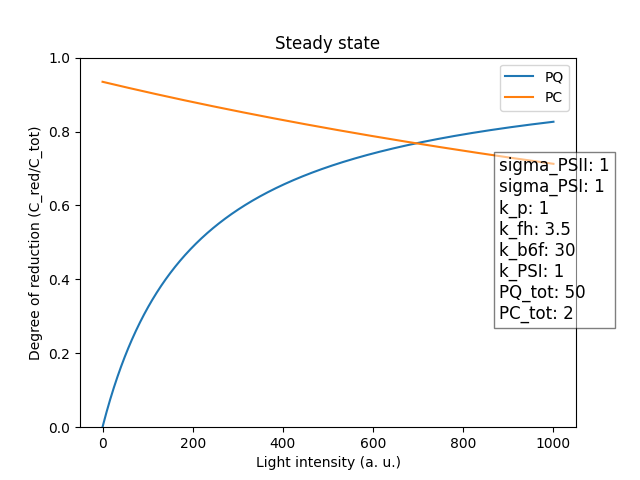

In [38]:
####### steady state light curve ########

importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import light_curve

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = 50
PC_tot = 2

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

### define light curve parameters ###

min_light = 0.1
max_light = 1000
light_steps = 1000


### run the model ###
light_range, X_PQ_red_steady, X_PC_red_steady = light_curve(min_light, max_light, light_steps, parameters)

### plot the results ###
    
fig, ax = plt.subplots()
ax.set_title('Steady state')
ax.plot(light_range, X_PQ_red_steady, label='PQ')
ax.plot(light_range, X_PC_red_steady, label='PC')
ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Light intensity (a. u.)')
ax.legend()

ax.set_ylim(0, 1)

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])

# Add the text box to the right of the plot but within the figure
plt.gcf().text(0.78, 0.5, parameters_str, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

fig.tight_layout()


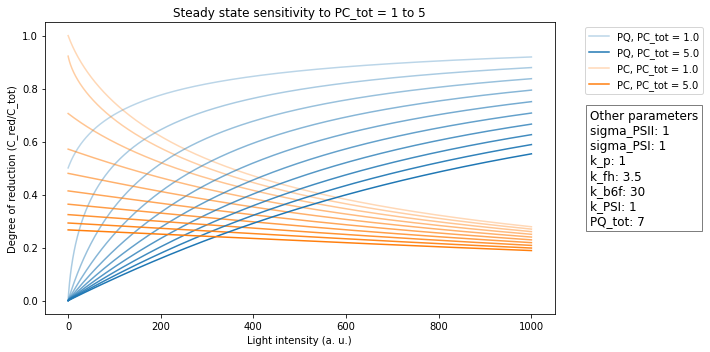

In [85]:
####### Parameter sensitivity of steady state solution #######

####### define all parameters ######

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = 7
PC_tot = 3

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'PC_tot'
min_value = 1
max_value = 5
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the light curve
min_light = 0.1
max_light = 1000
light_steps = 1000

# Create a dictionary to store the results
X_PQ_red_steady_values = np.zeros((n_values, light_steps))
X_PC_red_steady_values = np.zeros((n_values, light_steps))

# Run the light curve for each parameter value

for i, value in enumerate(parameter_values):
    parameters[parameter_to_vary] = value
    light_range, X_PQ_red_steady_values[i], X_PC_red_steady_values[i] = light_curve(min_light, max_light, light_steps, parameters)

# Plot the results
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Steady state sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax.plot(light_range, X_PQ_red_steady_values[i], color = "C0", alpha = alpha_values[i])
    ax.plot(light_range, X_PC_red_steady_values[i], color = "C1", alpha = alpha_values[i])

ax.plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax.plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'
    
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))


ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Light intensity (a. u.)')

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_steady_state_{parameter_to_vary}.png", dpi=300)


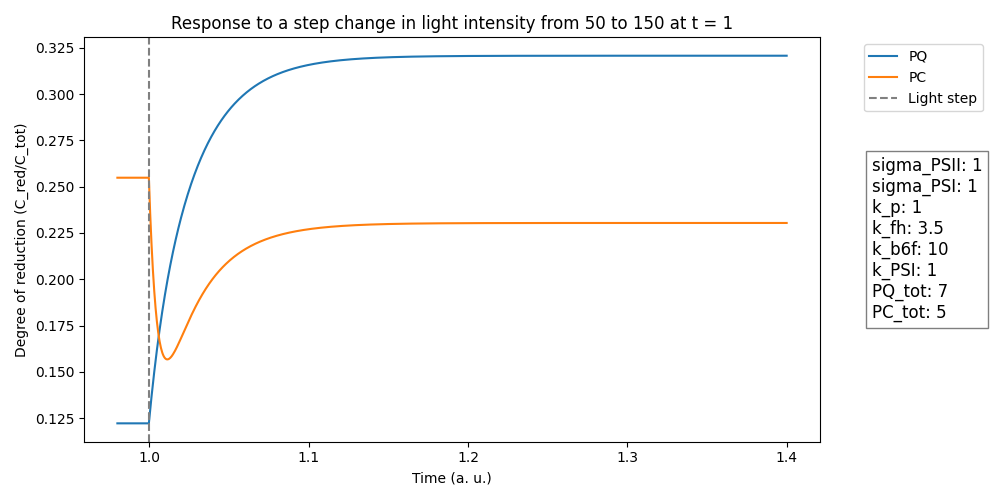

In [13]:
######## Dynamic response to a step change in light intensity ########

importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import response_step

### define model parameters ###

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

### define the time points for the simulation ###
t_start = 0.98
t_end = 1.4
n_points = 1000

### define the actinic light ###
light_1 = 50
light_2 = 150
time_light = 1

### run the model ###

time, light, X_PQ_red, X_PC_red = response_step(light_1, light_2, time_light, t_start, t_end, n_points, parameters)
    
### plot the results ###
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Response to a step change in light intensity from {light_1} to {light_2} at t = {time_light}")
ax.plot(time, X_PQ_red, label='PQ')
ax.plot(time, X_PC_red, label='PC')
ax.axvline(time_light, color='gray', linestyle='--', label='Light step')

ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Time (a. u.)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))


fig.tight_layout()    


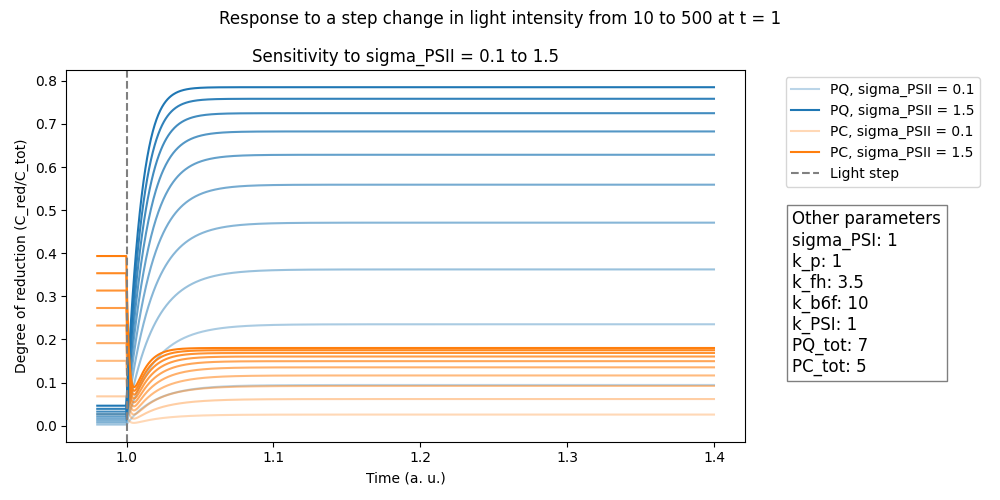

In [14]:
#### Parameter sensitivity of dynamic response to a step change in light intensity ####

# define all parameters 

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'sigma_PSII'
min_value = 0.1
max_value = 1.5
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the time points
t_start = 0.98
t_end = 1.4
n_points = 1000

# Define the actinic light step
light_1 = 10
light_2 = 500
time_light = 1

# Create a dictionary to store the results
X_PQ_red = np.zeros((n_values, n_points))
X_PC_red = np.zeros((n_values, n_points))

# Run the dynamic response for each parameter value
for i, value in enumerate(parameter_values):
    parameters[parameter_to_vary] = value
    time, light, X_PQ_red[i], X_PC_red[i] = response_step(light_1, light_2, time_light, t_start, t_end, n_points, parameters)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(f"Response to a step change in light intensity from {light_1} to {light_2} at t = {time_light}")
ax.set_title(f"Sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax.plot(time, X_PQ_red[i], color = "C0", alpha = alpha_values[i])
    ax.plot(time, X_PC_red[i], color = "C1", alpha = alpha_values[i])
    
ax.plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax.plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")
ax.axvline(time_light, color='gray', linestyle='--', label='Light step')
ax.set(xlabel='Time (a. u.)', ylabel='Degree of reduction (C_red/C_tot)')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'

ax.text(1.07, 0.4, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_step_response_{parameter_to_vary}.png", dpi=300)


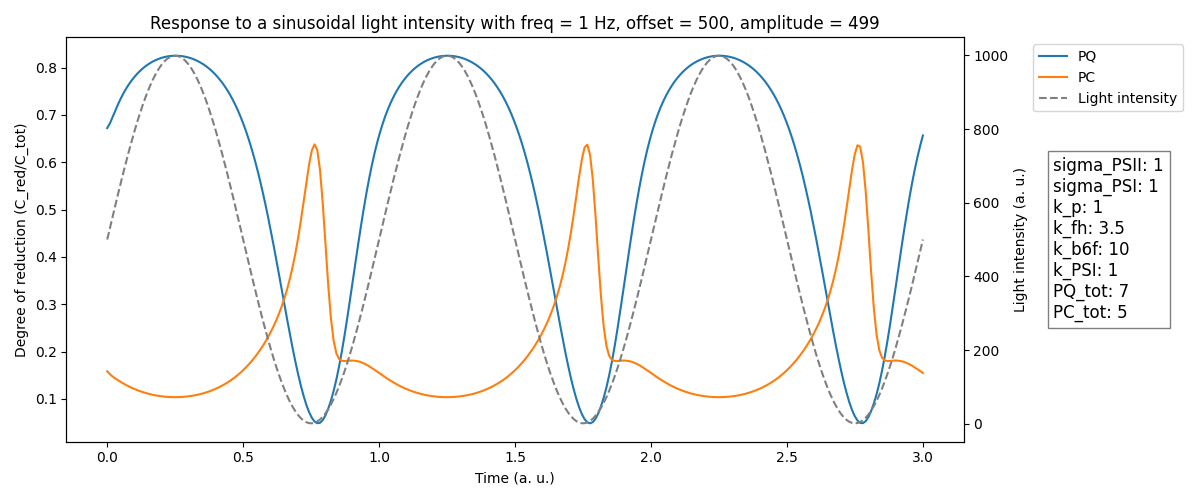

In [15]:
####### Dynamic response to a sinusoidal light intensity #######

importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import response_sinusoid

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))


freq = 1 #Hz

# Define acquisition parameters 

nb_periods = 3
points_per_period = 100

# Define the light intensity

offset = 500
amplitude = 499

# Run the model

time, light, X_PQ_red, X_PC_red = response_sinusoid(freq, nb_periods, points_per_period, offset, amplitude, parameters)

# Plot the results

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(f"Response to a sinusoidal light intensity with freq = {freq} Hz, offset = {offset}, amplitude = {amplitude}")
ax.plot(time, X_PQ_red, label='PQ')
ax.plot(time, X_PC_red, label='PC')
ax2 = ax.twinx()
ax2.plot(time, light, color='gray', linestyle='--')
ax.plot([], [], color='gray', linestyle='--', label='Light intensity')
ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Time (a. u.)')
ax2.set_ylabel('Light intensity (a. u.)')
ax.legend(bbox_to_anchor=(1.07, 1), loc='upper left')
fig.tight_layout()

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax.text(1.1, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.savefig(fig_folder + f"sinusoidal_light_f_{freq}_Hz_amp_{amplitude}_offset_{offset}.png", dpi=300)


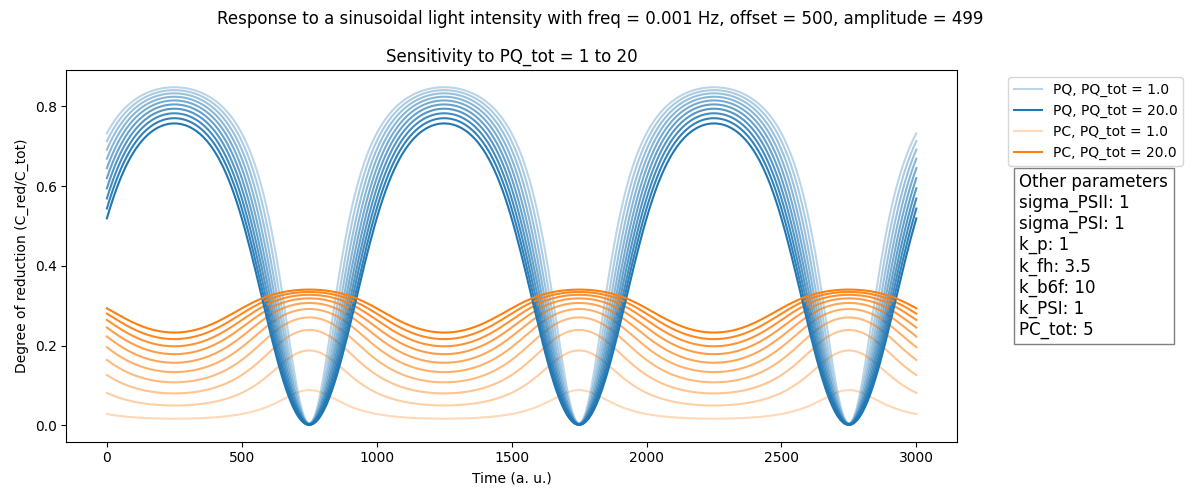

In [16]:
####### Parameter sensitivity of dynamic response to a sinusoidal light intensity #######

# define all parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5


parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'PQ_tot'
min_value = 1
max_value = 20
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the sinusoidal light
freq = 0.001
nb_periods = 3
points_per_period = 100
offset = 500
amplitude = 499

# Create a dictionary to store the results
X_PQ_red = np.zeros((n_values, nb_periods * points_per_period))
X_PC_red = np.zeros((n_values, nb_periods * points_per_period))

# Run the dynamic response for each parameter value
for i, value in enumerate(parameter_values):
    parameters[parameter_to_vary] = value
    time, light, X_PQ_red[i], X_PC_red[i] = response_sinusoid(freq, nb_periods, points_per_period, offset, amplitude, parameters)
    
# Plot the results
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle(f"Response to a sinusoidal light intensity with freq = {freq} Hz, offset = {offset}, amplitude = {amplitude}")
ax.set_title(f"Sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax.plot(time, X_PQ_red[i], color = "C0", alpha = alpha_values[i])
    ax.plot(time, X_PC_red[i], color = "C1", alpha = alpha_values[i])

ax.plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax.plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")
ax.set(xlabel='Time (a. u.)', ylabel='Degree of reduction (C_red/C_tot)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'
    
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_sinusoidal_{parameter_to_vary}.png", dpi=300)


In [20]:
####### Bode plot of the dynamic response to a sinusoidal light intensity #######

importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import simulate_bode_plot

# define the acquisition parameters

freq_min = 0.01
freq_max = 1000
nb_freqs = 20

nb_periods = 20
points_per_period = 100
period_start_fft = 10

# define the light intensity

offset = 400
amplitude = 100

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 50
PC_tot = 2

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# run the model

harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red = simulate_bode_plot(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters)



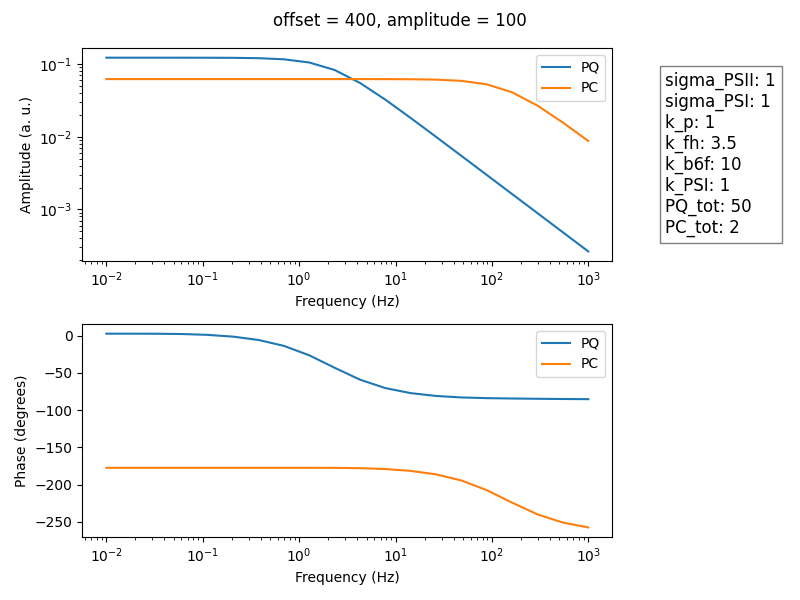

In [21]:
# Plot the results

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f"offset = {offset}, amplitude = {amplitude}")
ax[0].loglog(frequencies, harmonics_PQ['A_0'], label='PQ')
ax[0].loglog(frequencies, harmonics_PC['A_0'], label='PC')
ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend()
ax[1].semilogx(frequencies, harmonics_PQ['P_0'] + 90 , label='PQ')
ax[1].semilogx(frequencies, harmonics_PC['P_0'] + 90 - 360, label='PC')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')
ax[1].legend()

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax[0].text(1.1, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()


In [82]:
###### Parameter sensitivity of the Bode plot ######
from tqdm.notebook import tqdm
importlib.reload(skeleton_model_v1_functions)
# define all parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = 7
PC_tot = 3


parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'PC_tot'
min_value = 1
max_value = 5
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the Bode plot
freq_min = 0.01
freq_max = 1000
nb_freqs = 50
nb_periods = 20
points_per_period = 100
period_start_fft = 10 
offset = 100
amplitude = 10

# Create a dictionary to store the results
harmonics_PQ_values = []
harmonics_PC_values = []
X_PC_red_values = []
X_PQ_red_values = []

# Run the Bode plot for each parameter value
from multiprocessing import Pool
from tqdm.notebook import tqdm
importlib.reload(skeleton_model_v1_functions)
from skeleton_model_v1_functions import run_simulation_with_params 

if __name__ == '__main__':
    with Pool(processes=5) as pool:
        args = [(i, parameters, parameter_to_vary, parameter_values, freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude) for i in range(n_values)]
        results = list(pool.starmap(run_simulation_with_params, args))

    harmonics_PQ_values = [result[0] for result in results]
    harmonics_PC_values = [result[1] for result in results]
    X_PQ_red_values = [result[2] for result in results]
    X_PC_red_values = [result[3] for result in results]
    
frequencies = results[0][4]
times = results[0][5]



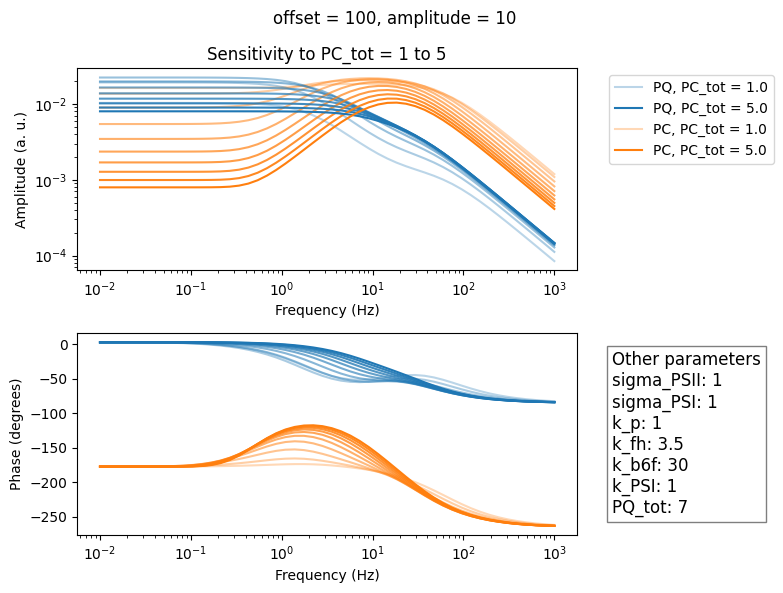

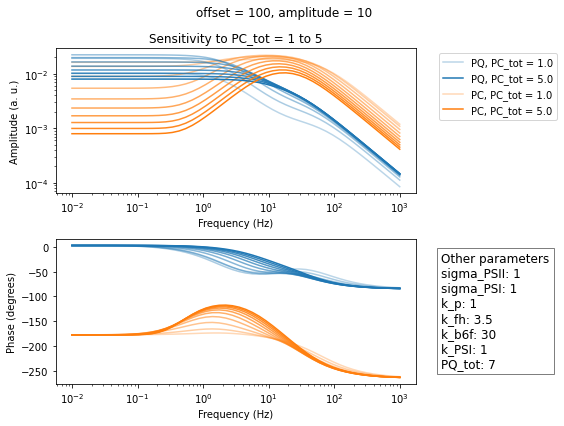

In [84]:
# Plot the results
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f"offset = {offset}, amplitude = {amplitude}")
ax[0].set_title(f"Sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax[0].loglog(frequencies, harmonics_PQ_values[i]['A_0'], color = "C0", alpha = alpha_values[i])
    ax[0].loglog(frequencies, harmonics_PC_values[i]['A_0'], color = "C1", alpha = alpha_values[i])
    ax[1].semilogx(frequencies, harmonics_PQ_values[i]['P_0'] + 90, color = "C0", alpha = alpha_values[i])
    ax[1].semilogx(frequencies, harmonics_PC_values[i]['P_0'] + 90 - 360, color = "C1", alpha = alpha_values[i])

ax[0].plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax[0].plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax[0].plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax[0].plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")

ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'
    
ax[1].text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_bode_{parameter_to_vary}_offset_{offset}_amp_{amplitude}_{min_value}_{max_value}_test_uncoupled.png", dpi=300)


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import matplotlib.gridspec as gridspec

# Assuming parameter_values, frequencies, times, X_PQ_red_values, X_PC_red_values are defined elsewhere

# Create sliders for parameter and frequency
param_slider = widgets.SelectionSlider(
    options=parameter_values,
    value=parameter_values[0],
    description=f'{parameter_to_vary}:',
    continuous_update=False
)

freq_slider = widgets.SelectionSlider(
    options=frequencies,
    value=frequencies[0],
    description='Frequency:',
    continuous_update=False
)

parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'

# Define the update function
def update_plot(param, frequency):
    i_param = np.where(parameter_values == param)[0][0]
    i_freq = np.where(frequencies == frequency)[0][0]
    
    thin = 1
    thick = 3
    
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 2)
    ax = fig.add_subplot(gs[:, 0])
    ax.plot(times[i_freq], X_PQ_red_values[i_param][i_freq], label='PQ')
    ax.plot(times[i_freq], X_PC_red_values[i_param][i_freq], label='PC')
    ax.set_title(f'{parameter_to_vary}: {parameter_values[i_param]:.2f}, Frequency: {frequencies[i_freq]:.2f} Hz')
    ax.set_xlabel('Time (a. u.)')
    ax.set_ylabel('Degree of reduction (C_red/C_tot)')
    ax.legend()
    ax.set_ylim(0, 1)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    for i, value in enumerate(parameter_values):
        ax2.loglog(frequencies, harmonics_PQ_values[i]['A_0'], color = "C0", alpha = alpha_values[i], linewidth = thin)
        ax2.loglog(frequencies, harmonics_PC_values[i]['A_0'], color = "C1", alpha = alpha_values[i], linewidth = thin)
        ax2.axvline(frequencies[i_freq], color='gray', linestyle='--')
        ax3.semilogx(frequencies, harmonics_PQ_values[i]['P_0'] + 90, color = "C0", alpha = alpha_values[i], linewidth = thin)
        ax3.semilogx(frequencies, harmonics_PC_values[i]['P_0'] + 90 - 360, color = "C1", alpha = alpha_values[i], linewidth = thin)
        ax3.axvline(frequencies[i_freq], color='gray', linestyle='--')
    
    ax2.loglog(frequencies, harmonics_PQ_values[i_param]['A_0'], color = "C0", linewidth=thick)
    ax2.loglog(frequencies, harmonics_PC_values[i_param]['A_0'], color = "C1", linewidth=thick)
    ax3.semilogx(frequencies, harmonics_PQ_values[i_param]['P_0'] + 90, color = "C0", linewidth=thick)
    ax3.semilogx(frequencies, harmonics_PC_values[i_param]['P_0'] + 90 - 360, color = "C1", linewidth=thick)
    
    ax2.set_title(f"Sensitivity to {parameter_to_vary}")
    ax2.set_ylabel('Amplitude (a. u.)')
    ax2.set_xlabel('Frequency (Hz)')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Phase (degrees)') 
    
    ax3.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.5))

    
    plt.tight_layout()
    plt.show()

# Use interact to link the sliders to the update function
interact(update_plot, param=param_slider, frequency=freq_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='PQ_tot:', options=(1.0, 6.44444444…

<function __main__.update_plot(param, frequency)>

In [ ]:
from pqdm.processes import pqdm
import time

def process_data(data):
    time.sleep(10) # simulate a longer-running task
    return data * 2

if __name__ == '__main__':
    data = range(100)
    processed_data = pqdm(data, process_data, n_jobs=5, desc='Processing data')

QUEUEING TASKS | Processing data:   0%|          | 0/100 [00:00<?, ?it/s]

PROCESSING TASKS | Processing data:   0%|          | 0/100 [00:00<?, ?it/s]

COLLECTING RESULTS | Processing data:   0%|          | 0/100 [00:00<?, ?it/s]